In [46]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
data = pd.read_csv('weatherAUS.csv')

In [11]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,1.0,0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.2,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [13]:
data.shape

(142193, 24)

In [5]:
##Convert 'RainToday' and 'RainTomorrow' into binary.
data['RainToday'].replace({'No':0, 'Yes':1}, inplace=True)
data['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace=True)

In [6]:
##Check for seeing if the data is balanced among these two columns
data1_1 = pd.DataFrame(data[['RainToday']].value_counts(normalize=True).reset_index())
data1_2 = pd.DataFrame(data[['RainTomorrow']].value_counts(normalize=True).reset_index())
data1_1.set_axis(['Index','Ratio_RainToday'], axis="columns", inplace=True)
data1_2.set_axis(['Index','Ratio_RainTomorrow'], axis="columns", inplace=True)
data1 = pd.merge(data1_1, data1_2, on='Index')

In [8]:
fig1 = px.bar(data1, x='Index', y=['Ratio_RainToday', 'Ratio_RainTomorrow'], barmode='group', text_auto=True, title='Ratio of RainToday and RainTomorrow by the prediction', color_discrete_sequence=['skyblue', 'navy'])
fig1.show()#This displays that both the Column data are imbalanced.

In [14]:
## To fight this class imbalance we use the resample function from the sklearn.utils to oversample the minority class
no = data[data.RainTomorrow == 0]
yes = data[data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

In [15]:
data2 = pd.DataFrame(oversampled[['RainTomorrow']].value_counts(normalize=True).reset_index())
data2.set_axis(['Index','Ratio_RainTomorrow'], axis="columns", inplace=True)

In [16]:
fig2 = px.bar(data2, x='Index', y='Ratio_RainTomorrow', text_auto=True, title='Ratio after Balancing the two classes')
fig2.show()#this show that infact the classes were balanced

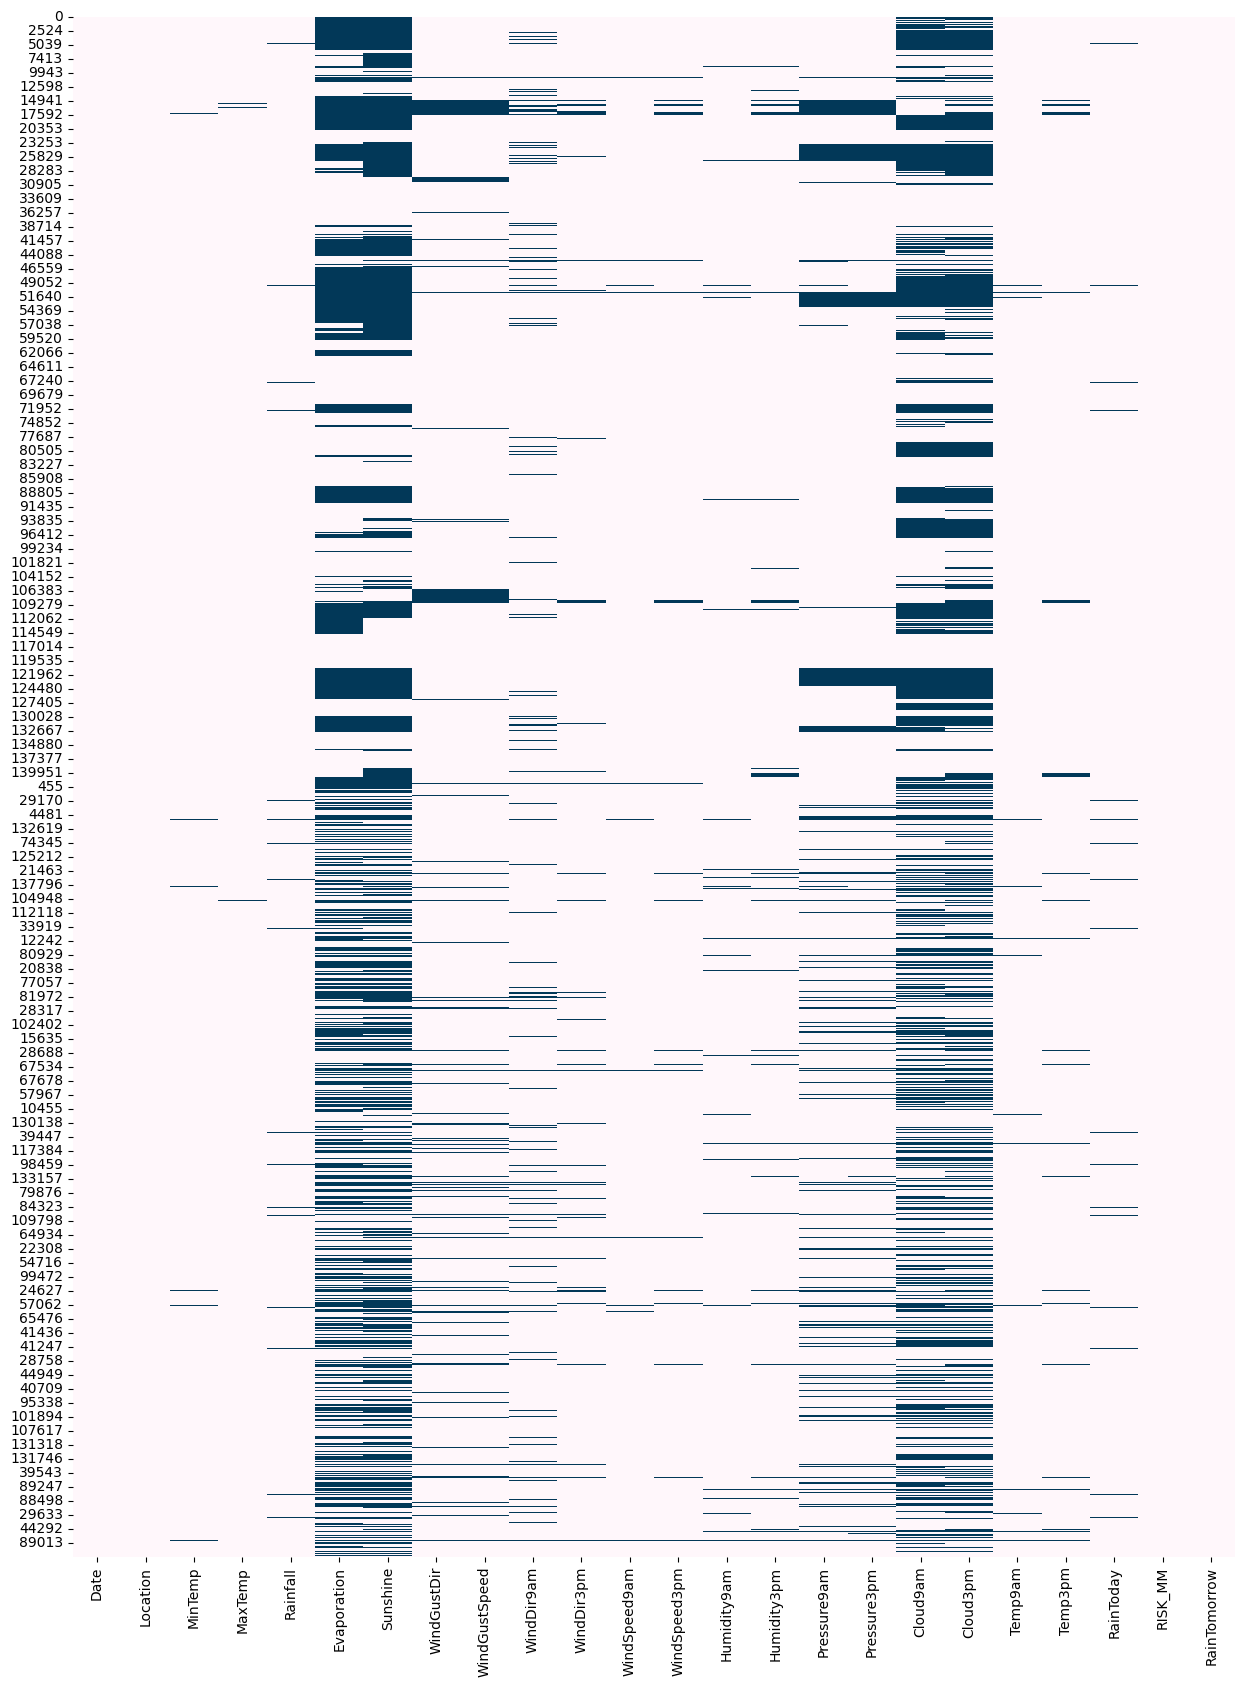

In [25]:
fig,ax = plt.subplots(figsize=(15,20))
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')
plt.show()

In [18]:
##finding the major value missing columns.
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing.head(10))#Dipslays the top value missing columns that are namely: Sunshine, Evaporation, Cloud3pm, Cloud9pm.

                Total   Percent
Sunshine       104831  0.475140
Evaporation     95411  0.432444
Cloud3pm        85614  0.388040
Cloud9am        81339  0.368664
Pressure3pm     21746  0.098562
Pressure9am     21728  0.098481
WindGustDir     15491  0.070212
WindGustSpeed   15354  0.069591
WindDir9am      14728  0.066754
WindDir3pm       6440  0.029189


In [19]:
#################################
##IMPUTATION AND TRANSFORMATION##
#################################

In [21]:
## We first detect the categorical columns and then impute those specific columns with mode() 
print(oversampled.select_dtypes(include=['object']).columns)

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')


In [26]:
## Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [27]:
## We use the LabelEncoder to convert these column entries into numeric quantities.
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [28]:
## Multiple Imputation by Chained Equations
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [29]:
MiceImputed

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,396.0,2.0,13.4,22.9,0.6,5.735438,7.364116,13.0,44.0,13.0,...,22.0,1007.7,1007.1,8.000000,4.868720,16.9,21.8,0.0,0.0,0.0
1,397.0,2.0,7.4,25.1,0.0,5.639582,11.470601,14.0,44.0,6.0,...,25.0,1010.6,1007.8,1.734671,2.639541,17.2,24.3,0.0,0.0,0.0
2,398.0,2.0,12.9,25.7,0.0,7.762987,12.281872,15.0,46.0,13.0,...,30.0,1007.6,1008.7,1.820254,2.000000,21.0,23.2,0.0,0.0,0.0
3,399.0,2.0,9.2,28.0,0.0,5.977338,11.743982,4.0,24.0,9.0,...,16.0,1017.6,1012.8,1.236006,2.133027,18.1,26.5,0.0,1.0,0.0
4,400.0,2.0,17.5,32.3,1.0,6.852950,5.756442,13.0,41.0,1.0,...,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0,0.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130416,950.0,17.0,1.1,11.8,0.4,-1.695532,0.725087,14.0,13.0,3.0,...,98.0,1020.1,1013.3,6.438835,7.620772,4.0,9.5,0.0,8.8,1.0
114384,3114.0,29.0,9.6,14.8,11.8,3.440786,4.300000,13.0,69.0,14.0,...,71.0,1015.4,1015.7,8.000000,8.000000,11.4,12.6,1.0,5.4,1.0
84962,503.0,8.0,24.8,31.5,0.0,5.400000,3.400000,9.0,48.0,10.0,...,60.0,1008.6,1006.2,5.000000,6.000000,28.7,30.3,0.0,9.8,1.0
54992,1721.0,5.0,4.2,7.9,11.4,0.275994,0.716987,12.0,63.0,6.0,...,93.0,997.2,998.9,8.000000,8.000000,4.6,6.8,1.0,18.4,1.0


In [30]:
## Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [31]:
## Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
print(MiceImputed.shape)

(156852, 24)


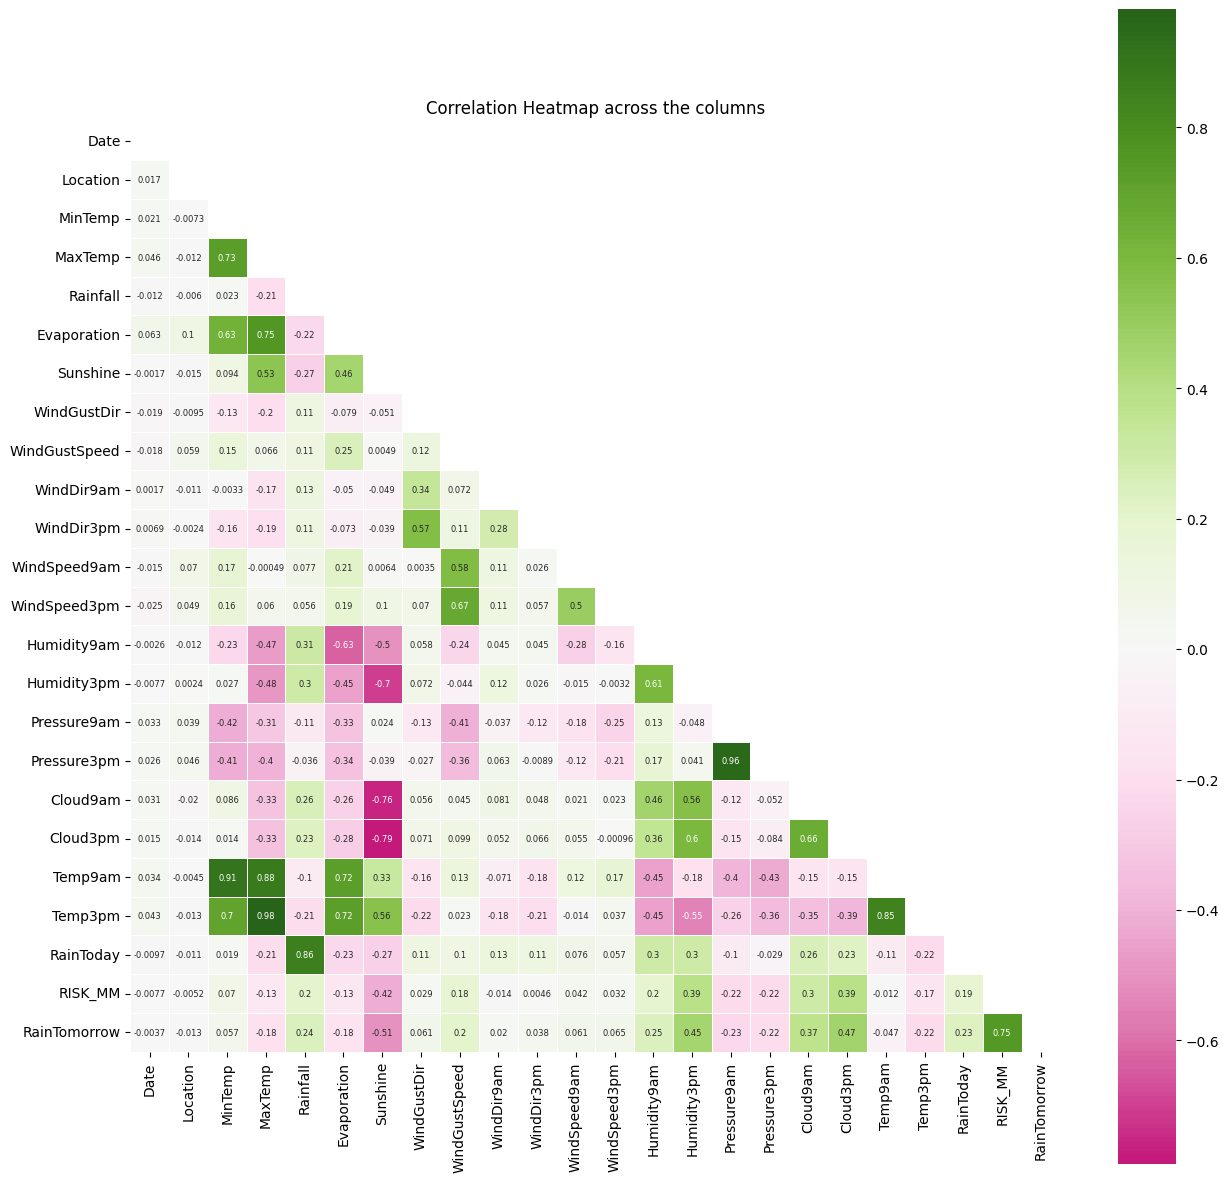

In [38]:
## Correlation Heatmap
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))#returns a 2D array where only the lower traingle values are 1s and rest are zero.
f, ax = plt.subplots(figsize=(15, 15))
plt.title('Correlation Heatmap across the columns')
sns.heatmap(corr, mask=mask, cmap='PiYG', center=0,square=True, annot=True, linewidths=.5, annot_kws={'size':6})
plt.show()

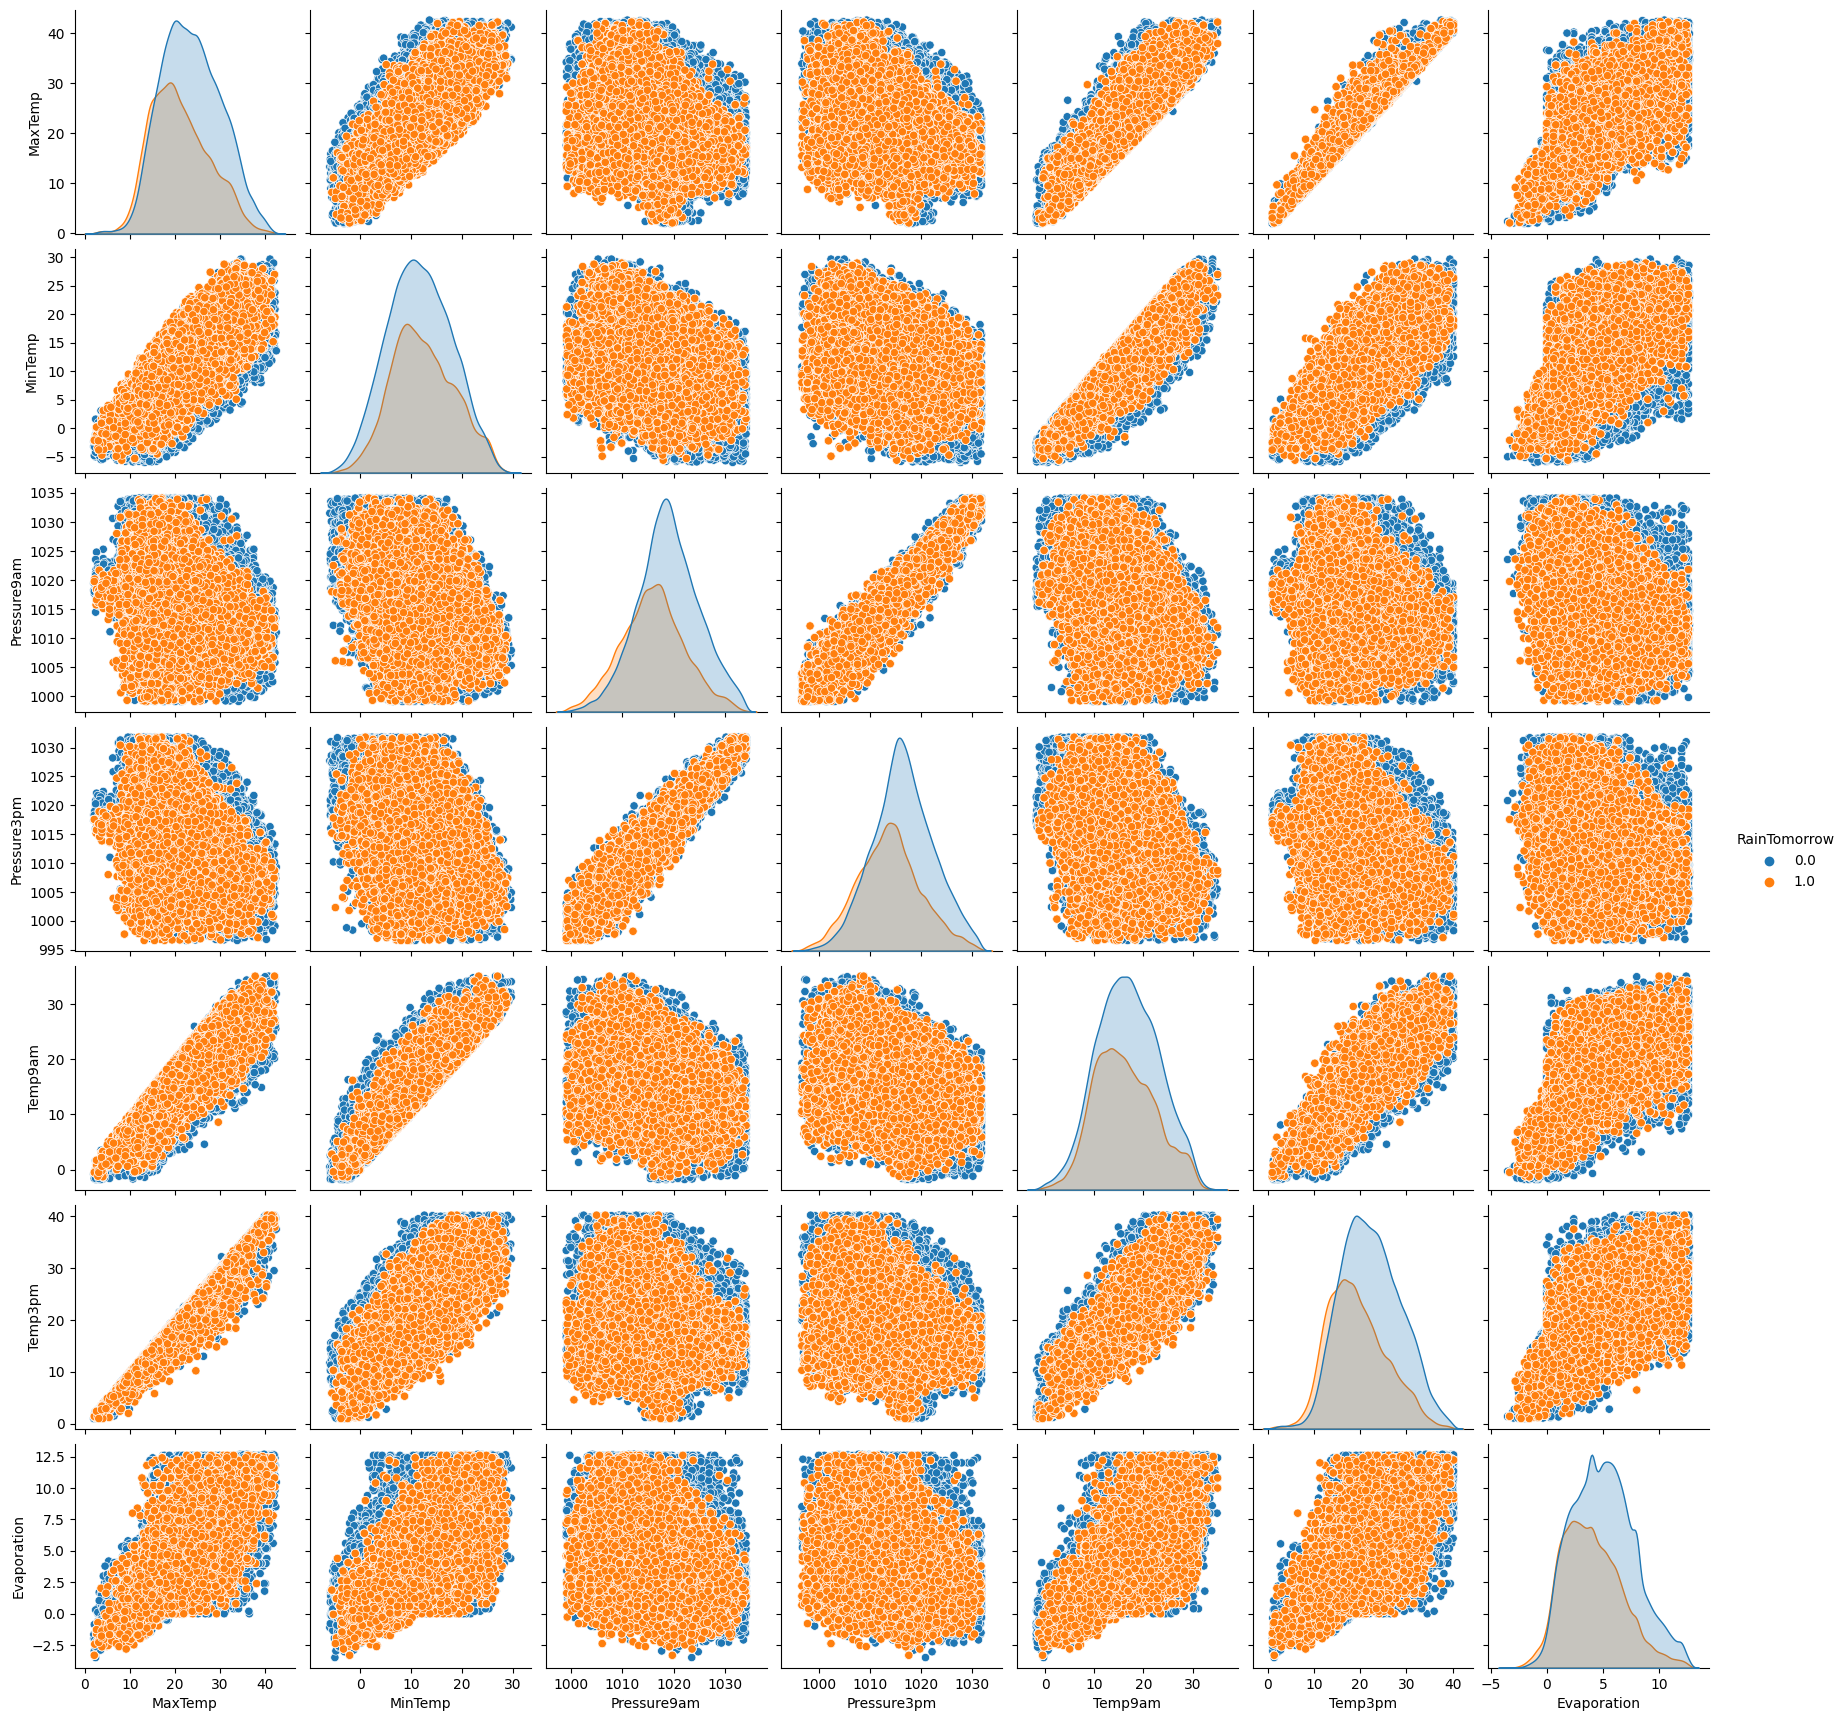

In [37]:
#Pair plot among the high correlation columns.
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )
plt.show()

In [42]:
####################################
##FEATURE SELECTION FOR PREDICTION##
####################################

In [44]:
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [45]:
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


In [47]:
X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00205993 0.00215407 0.00259089 0.00367568 0.0102656  0.00252838
 0.05894157 0.00143001 0.00797518 0.00177178 0.00167654 0.0014278
 0.00187743 0.00760691 0.03091966 0.00830365 0.01193018 0.02113544
 0.04962418 0.00270103 0.00513723 0.00352198 0.76074491]


In [48]:
######################################################
##TRAINING RAINFALL PREDICTION WITH DIFFERENT MODELS##
######################################################

In [49]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

In [50]:
# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [51]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [59]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.785428301838676
ROC Area under Curve = 0.7651966215587425
Cohen's Kappa = 0.5403005694563996
Time taken = 312.320876121521
              precision    recall  f1-score   support

         0.0    0.80468   0.85656   0.82981     23948
         1.0    0.74965   0.67383   0.70972     15265

    accuracy                        0.78543     39213
   macro avg    0.77717   0.76520   0.76977     39213
weighted avg    0.78326   0.78543   0.78306     39213



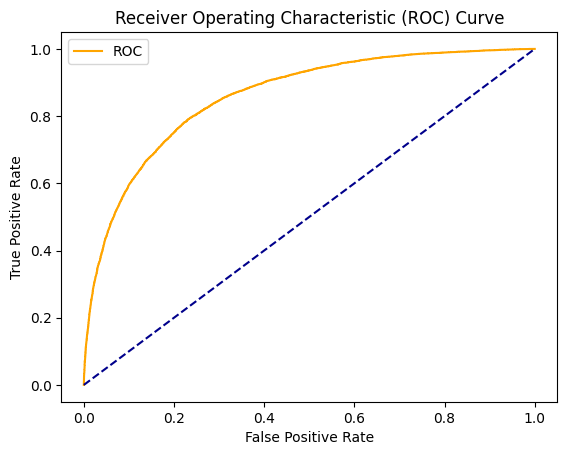

In [61]:
## Logistic Regression ##
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

Accuracy = 0.875806492744753
ROC Area under Curve = 0.8767068658586672
Cohen's Kappa = 0.7425666158537387
Time taken = 0.5073089599609375
              precision    recall  f1-score   support

         0.0    0.91989   0.87264   0.89564     23948
         1.0    0.81510   0.88077   0.84666     15265

    accuracy                        0.87581     39213
   macro avg    0.86749   0.87671   0.87115     39213
weighted avg    0.87909   0.87581   0.87657     39213



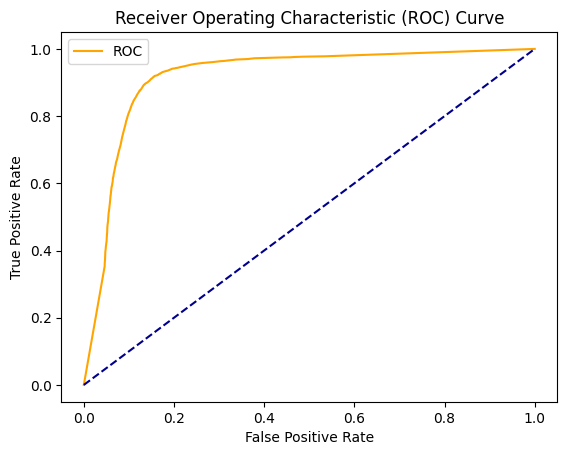

In [60]:
## Decision Tree ##
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

Accuracy = 0.7841022110014536
ROC Area under Curve = 0.7748944322590856
Cohen's Kappa = 0.547681465364799
Time taken = 449.54640340805054
              precision    recall  f1-score   support

         0.0    0.82768   0.81648   0.82204     23948
         1.0    0.71807   0.73331   0.72561     15265

    accuracy                        0.78410     39213
   macro avg    0.77287   0.77489   0.77382     39213
weighted avg    0.78501   0.78410   0.78450     39213



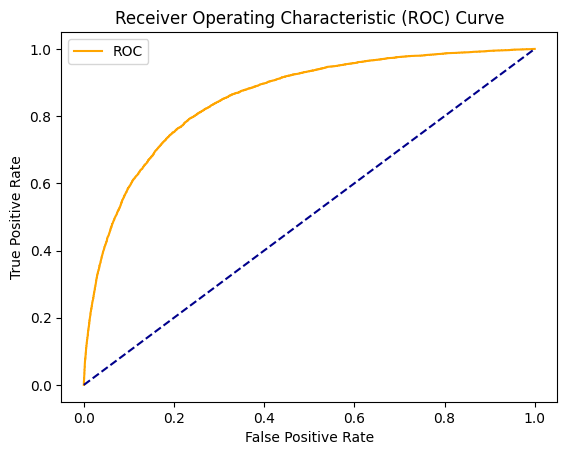

In [62]:
## Neural Network ##
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

Accuracy = 0.93463902277306
ROC Area under Curve = 0.9344221096248992
Cohen's Kappa = 0.8633994430607739
Time taken = 33.14865493774414
              precision    recall  f1-score   support

         0.0    0.95661   0.93540   0.94589     23948
         1.0    0.90206   0.93344   0.91748     15265

    accuracy                        0.93464     39213
   macro avg    0.92934   0.93442   0.93169     39213
weighted avg    0.93538   0.93464   0.93483     39213



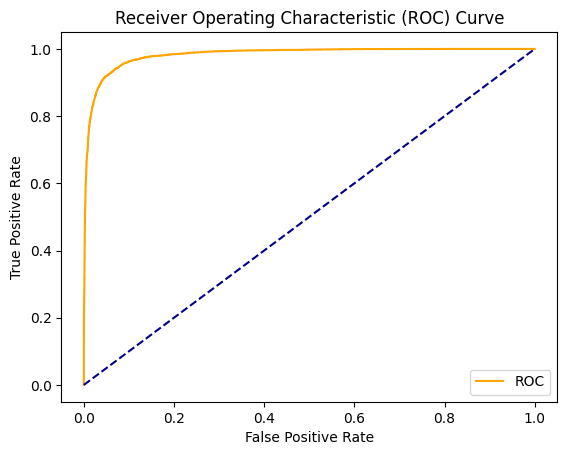

In [63]:
## Random Forest ##
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

In [64]:
####################
##MODEL COMPARISON##
####################

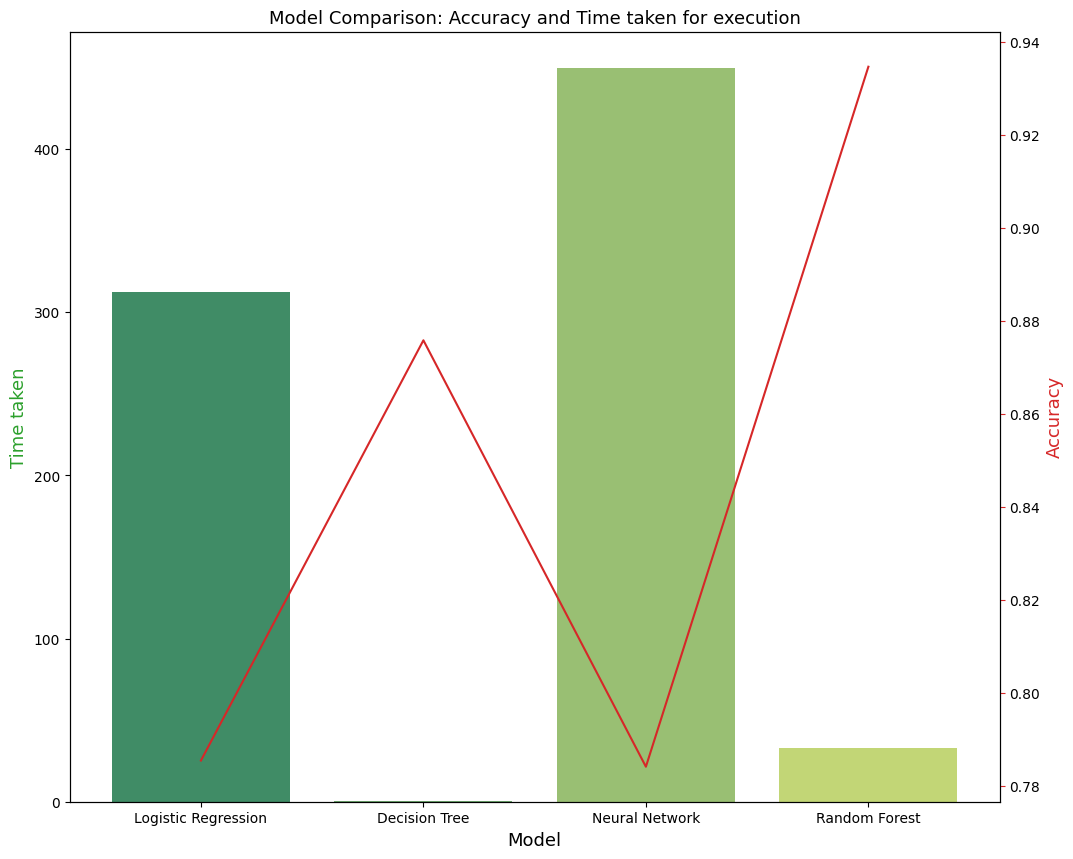

In [65]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf]
tt = [tt_lr, tt_dt, tt_nn, tt_rf]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

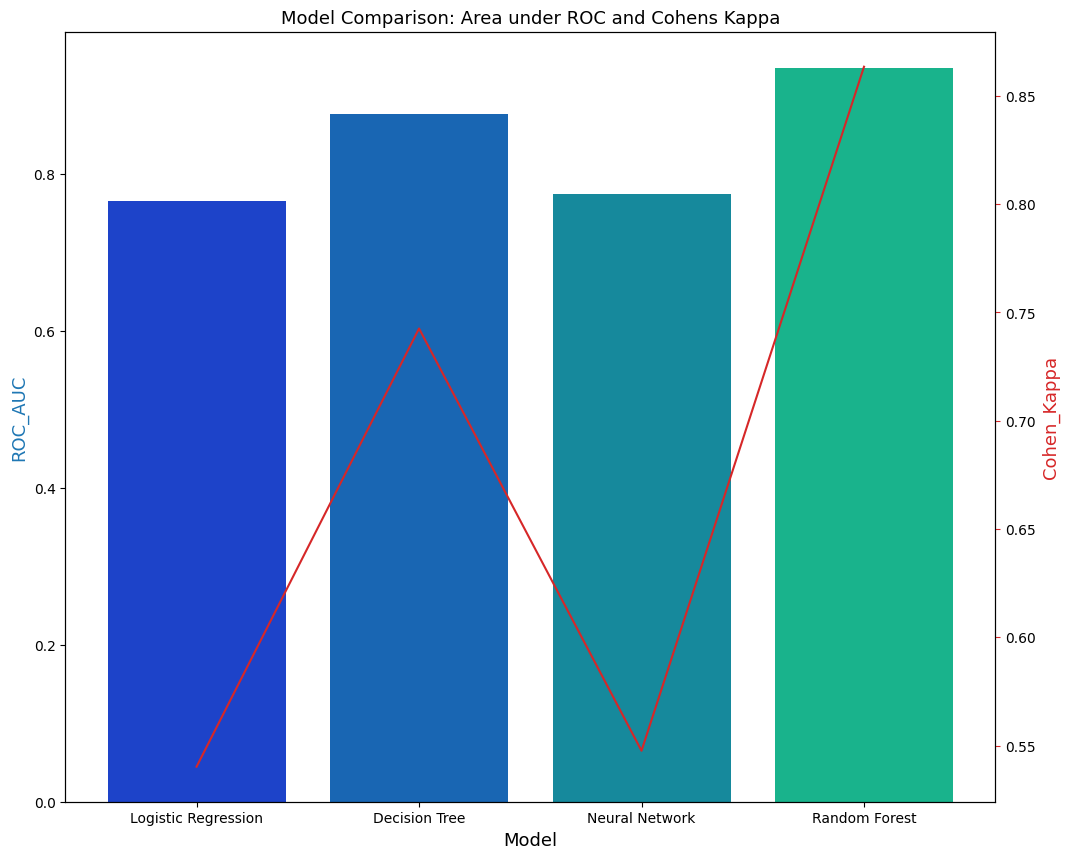

In [66]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()